[Elo](https://elo.com.br/) is a Brazillian debit and credit card brand.  They offer credit and prepaid transactions, and have paired up with merchants in order offer promotions to cardholders.  In order to offer more relevant and personalized promotions, in a [recent Kaggle competition](https://www.kaggle.com/c/elo-merchant-category-recommendation), Elo challenged Kagglers to predict customer loyalty based on transaction history.  Presumably they plan to use a loyalty-predicting model in order to determine what promotions to offer to customers based on how certain offers are predicted to effect card owners' card loyalty.

In previous kernels, we performed some [exploratory data analysis](http://www.kaggle.com/brendanhasz/elo-data-cleaning-and-eda), and then did some [feature engineering and selection](http://www.kaggle.com/brendanhasz/elo-feature-engineering-and-feature-selection). In this kernel, we'll build models to predict the customer loyalty given the features we engineered.  First we'll run some baseline models, then create some models which make use of outlier prediction, and finally construct ensemble and stacking models.

**Outline**

- [Loading the Data](#loading-the-data)
- [Evaluation Metric](#evaluation-metric)
- [Baseline](#baseline)
- [Gradient-boosted decision tree regression](#gradient-boosted-decision-tree-regression)
- [Predictions without outliers](#predictions-without-outliers)
- [Outlier prediction model](#outlier-prediction-model)
- [Hyperparameter Optimization](#hyperparameter-optimization)
- [Performance of Individual Models](#performance-of-individual-models)
- [Ensemble Model](#ensemble-model)
- [Stacking Model](#stacking-model)

In [1]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import BayesianRidge

from catboost import CatBoostRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor

!pip install git+http://github.com/brendanhasz/dsutils.git
from dsutils.encoding import TargetEncoderCV
from dsutils.optimization import optimize_params
from dsutils.ensembling import EnsembleRegressor, StackedRegressor

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

  Cloning http://github.com/brendanhasz/dsutils.git to /tmp/pip-req-build-ik9lgq7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-al265nkh/wheels/a1/ff/2a/75bdc08e9c96d4917294db5e6faf99ef3de673f37992c52278
Successfully built dsutils
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


<a id='loading-the-data'></a>
## Loading the Data

First, let's load the data which includes the features we engineered in the [last kernel](http://www.kaggle.com/brendanhasz/elo-feature-engineering-and-feature-selection).

In [2]:
# Load data containing all the features
fname = '../input/elo-feature-selection/card_features_top100.feather'
cards = pd.read_feather(fname)
cards.set_index('card_id', inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


Then, we can split the dataset into test vs train, and features (X) vs the target (y).

In [3]:
# Test indexes
test_ix = cards['target'].isnull()

# Test data
X_test = cards[test_ix]#TODO: .copy()
del X_test['target']

# Training data
cards_train = cards[~test_ix]#TODO: .copy()
y_train = cards_train['target']#TODO: .copy()
X_train = cards_train.copy()
del X_train['target']

# Clean up
del cards_train
del cards
gc.collect()

43

<a id='evaluation-metric'></a>
## Evaluation Metric

We'll be using the root mean squared error as our evaluation metric:

$$
RMSE(y, \hat{y}) = \sqrt{ \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2 }
$$

Unfortunately, sklearn doesn't have a built-in RMSE metric function, so we'll build our own.

In [4]:
def root_mean_squared_error(y_true, y_pred):
    """Root mean squared error regression loss"""
    return np.sqrt(np.mean(np.square(y_true-y_pred)))

And we'll also create a sklearn scorer corresponding to that metric:

In [5]:
rmse_scorer = make_scorer(root_mean_squared_error)

<a id='baseline'></a>
## Baseline

Before we start creating predictive models, it's good to have a baseline with which to compare our models' performance.  That way, if our models perform worse than the baseline, we'll know something's broken somewhere!  

Our predictive models should *definitely* be able to do better than if we just predict the mean loyalty score for each sample.  What RMSE can we acheive if we just predict the mean?

In [6]:
root_mean_squared_error(np.mean(y_train), y_train)

3.850490394908787

OK, so our models should *for sure* be getting RMSE values lower than 3.85.

<a id='gradient-boosted-decision-tree-regression'></a>
## Gradient-boosted decision tree regression

As a slightly more realistic baseline, let's first just use [CatBoost](http://catboost.ai) by itself, without any parameter tuning or anything fancy.  

Well, one fancy thing: we'll also target-encode the categorical columns.  The only categorical columns in the dataset were created by taking the most common category during an aggregation, and so they all have 'mode' in their column name.

In [7]:
%%time

# Categorical columns
cat_cols = [c for c in X_train if 'mode' in c] 

# Regression pipeline
model = Pipeline([
    ('targ_enc',  TargetEncoderCV(cols=cat_cols)),
    ('scaler',    RobustScaler()),
    ('imputer',   SimpleImputer(strategy='median')),
    ('regressor', CatBoostRegressor(verbose=False))
])

# Cross-validated performance
scores = cross_val_score(model, X_train, y_train, 
                         cv=3, scoring=rmse_scorer)
print('Cross-validated MSE: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

Cross-validated MSE: 3.668 +/- 0.020
CPU times: user 24min 1s, sys: 32.2 s, total: 24min 33s
Wall time: 15min 14s


So just with CatBoost, we can do better than just predicting the mean.  But not a whole lot better!  Let's see if we can improve our predictive performance by creating more complex models.

<a id='predictions-without-outliers'></a>
## Predictions without outliers

One weird thing about the target is that there's a lot of outliers:

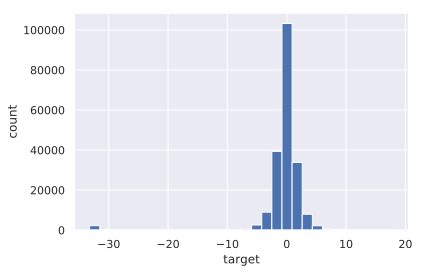

In [8]:
# Show histogram of target
y_train.hist(bins=30)
plt.xlabel('target')
plt.ylabel('count')
plt.show()

All the outliers have exactly the same value:

In [9]:
y_train[y_train<-20].unique()

array([-33.21928024])

And around 1% of the samples have these outlier values:

In [10]:
print('Percent of targets which are outliers:', 100*np.mean(y_train<-20))

Percent of targets which are outliers: 1.0930233709890698


Those outliers are probably having an outsized effect on the training of the model.  It might be best to just train the model w/o including the outliers.  To try that, we'll build a function which lets us specify what samples to use for testing and training.  Then, we can use that function to compute the cross-validated performance of our regressor when we train using only the non-outlier data.


In [11]:
def cross_val_metric(model, X, y, cv=3, 
                     metric=root_mean_squared_error, 
                     train_subset=None, test_subset=None, 
                     shuffle=False, display=None):
    """Compute a cross-validated metric for a model.
    
    Parameters
    ----------
    model : sklearn estimator or callable
        Model to use for prediction.  Either an sklearn estimator (e.g. a 
        Pipeline), or a function which takes 3 arguments: 
        (X_train, y_train, X_test), and returns y_pred.  X_train and X_test
        should be pandas DataFrames, and y_train and y_pred should be 
        pandas Series.
    X : pandas DataFrame
        Features.
    y : pandas Series
        Target variable.
    cv : int
        Number of cross-validation folds
    metric : sklearn.metrics.Metric
        Metric to evaluate.
    train_subset : pandas Series (boolean)
        Subset of the data to train on. 
        Must be same size as y, with same index as X and y.
    test_subset : pandas Series (boolean)
        Subset of the data to test on.  
        Must be same size as y, with same index as X and y.
    shuffle : bool
        Whether to shuffle the data. Default = False
    display : None or str
        Whether to print the cross-validated metric.
        If None, doesn't print.
    
    Returns
    -------
    metrics : list
        List of metrics for each test fold (length cv)
    preds : pandas Series
        Cross-validated predictions
    """
    
    # Use all samples if not specified
    if train_subset is None:
        train_subset = y.copy()
        train_subset[:] = True
    if test_subset is None:
        test_subset = y.copy()
        test_subset[:] = True
    
    # Perform the cross-fold evaluation
    metrics = []
    TRix = y.copy()
    TEix = y.copy()
    all_preds = y.copy()
    kf = KFold(n_splits=cv, shuffle=shuffle)
    for train_ix, test_ix in kf.split(X):
        
        # Indexes for samples in training fold and in train_subset
        TRix[:] = False
        TRix.iloc[train_ix] = True
        TRix = TRix & train_subset
        
        # Indexes for samples in test fold and in test_subset
        TEix[:] = False
        TEix.iloc[test_ix] = True
        TEix = TEix & test_subset
        
        # Predict using a function
        if callable(model):
            preds = model(X.loc[TRix,:], y[TRix], X.loc[TEix,:])
        else:
            model.fit(X.loc[TRix,:], y[TRix])
            preds = model.predict(X.loc[TEix,:])
        
        # Store metrics for this fold
        metrics.append(metric(y[TEix], preds))
        
        # Store predictions for this fold
        all_preds[TEix] = preds

    # Print the metric
    metrics = np.array(metrics)
    if display is not None:
        print('Cross-validated %s: %0.3f +/- %0.3f'
              % (display, metrics.mean(), metrics.std()))
        
    # Return a list of metrics for each fold
    return metrics, all_preds

Now, we can train the same model as before, but only on datapoints which are *not* outliers, and then test its cross-validated performance on all the data.

In [12]:
%%time

# Compute which samples are outliers
nonoutliers = y_train>-20

# Cross-validated performance training only on non-outliers
cross_val_metric(model, X_train, y_train, cv=3, 
                 metric=root_mean_squared_error, 
                 train_subset=nonoutliers,
                 display='RMSE')

Cross-validated RMSE: 3.809 +/- 0.020
CPU times: user 25min 17s, sys: 43.3 s, total: 26min 1s
Wall time: 16min 46s


Hmm, that didn't seem to help at all.  The model still performs better than just guessing the mean (a RMSE of 3.85), but doesn't beat simply using CatBoost on all the data by a long shot (which results in a RMSE of 3.67).

<a id='outlier-prediction-model'></a>
## Outlier prediction model

It may work better to train one model to try and predict whether a sample will be an outlier or not, and then train another model on the non-outlier data.

Let's create a classification model to classify outlier vs. non-outlier, and a regression model to estimate the values of non-outlier data.  And we'll use XGBoost for the classifier instead of CatBoost, because what the hey.

In [13]:
# Classification pipeline
classifier = Pipeline([
    ('targ_enc',   TargetEncoderCV(cols=cat_cols)),
    ('scaler',     RobustScaler()),
    ('imputer',    SimpleImputer(strategy='median')),
    ('classifier', XGBClassifier())
])

# Regression pipeline
regressor = Pipeline([
    ('targ_enc',  TargetEncoderCV(cols=cat_cols)),
    ('scaler',    RobustScaler()),
    ('imputer',   SimpleImputer(strategy='median')),
    ('regressor', CatBoostRegressor())
])

Then, we can use the classification model to predict the probability that each test sample is an outlier, and the regression model to estimate the value for non-outlier values.  For samples which the classifier predicts are outliers, we'll just set the predicted value to be the outlier value (`-33.2`...).  For samples which the classifier predicts are *not* outliers, we'll use the regression model to predict the value.

In order to evaluate our model with cross-fold validation, we'll create a function which performs the whole (somewhat non-orthodox) pipeline.

In [14]:
def classifier_regressor(X_tr, y_tr, X_te):
    """Classify outliers, and set to outlier value if a predicted outlier
    else use a regressor trained on non-outliers
    
    Parameters
    ----------
    X_tr : pandas DataFrame
        Training features
    y_tr : pandas Series
        Training target
    X_te : pandas DataFrame
        Test features
        
    Returns
    -------
    y_pred : pandas Series
        Predicted y values for samples in X_te
    """
    
    # Fit the classifier to predict outliers
    outliers = y_tr<-20
    fit_classifier = classifier.fit(X_tr, outliers)
    
    # Samples which do not have outlier target values
    X_nonoutlier = X_tr.loc[~outliers, :]
    y_nonoutlier = y_tr[~outliers]

    # Fit the regressor to estimate non-outlier targets
    fit_regressor = regressor.fit(X_nonoutlier, y_nonoutlier)
    
    # Predict outlier probability
    pred_outlier = fit_classifier.predict_proba(X_te)[:,1]

    # Estimate target
    y_pred = fit_regressor.predict(X_te)
    
    # Estimate number of outliers in test data
    outlier_num = int(X_te.shape[0]*np.mean(outliers))

    # Set that proportion of top estimated outliers to outlier value
    thresh = np.sort(pred_outlier)[-outlier_num]
    y_pred[pred_outlier>thresh] = -33.21928024
    
    # Return predictions
    return y_pred

Now we can evaluate the model's performance:

In [15]:
%%time

# Performance of mixed classifier + regressor
cross_val_metric(classifier_regressor, 
                 X_train, y_train,
                 metric=root_mean_squared_error, 
                 cv=3, display='RMSE')

0:	learn: 1.7039567	total: 86.6ms	remaining: 1m 26s
1:	learn: 1.6988167	total: 168ms	remaining: 1m 24s
2:	learn: 1.6938471	total: 250ms	remaining: 1m 23s
3:	learn: 1.6892190	total: 335ms	remaining: 1m 23s
4:	learn: 1.6849310	total: 415ms	remaining: 1m 22s
5:	learn: 1.6806785	total: 498ms	remaining: 1m 22s
6:	learn: 1.6767520	total: 577ms	remaining: 1m 21s
7:	learn: 1.6727762	total: 663ms	remaining: 1m 22s
8:	learn: 1.6691245	total: 743ms	remaining: 1m 21s
9:	learn: 1.6657933	total: 826ms	remaining: 1m 21s
10:	learn: 1.6625996	total: 911ms	remaining: 1m 21s
11:	learn: 1.6593923	total: 996ms	remaining: 1m 21s
12:	learn: 1.6563732	total: 1.08s	remaining: 1m 21s
13:	learn: 1.6534833	total: 1.16s	remaining: 1m 22s
14:	learn: 1.6509190	total: 1.25s	remaining: 1m 21s
15:	learn: 1.6482747	total: 1.34s	remaining: 1m 22s
16:	learn: 1.6458387	total: 1.43s	remaining: 1m 22s
17:	learn: 1.6435351	total: 1.51s	remaining: 1m 22s
18:	learn: 1.6412194	total: 1.6s	remaining: 1m 22s
19:	learn: 1.6390973	t

(array([4.58081878, 4.60178933, 4.58996714]), card_id
 C_ID_92a2005557   -0.173507
 C_ID_3d0044924f    0.133273
 C_ID_d639edf6cd    0.453577
 C_ID_186d6a6901    0.410706
 C_ID_cdbd2c0db2   -0.072219
 C_ID_0894217f2f   -0.564733
 C_ID_7e63323c00   -0.416603
 C_ID_dfa21fc124    0.014913
 C_ID_fe0fdac8ea    0.289756
 C_ID_bf62c0b49d    0.219142
 C_ID_92853cdb2c   -0.511604
 C_ID_269d816788    0.678927
 C_ID_61d50d7057    0.656185
 C_ID_4e07413433   -0.531190
 C_ID_b6302b31c6   -0.619592
 C_ID_3b69154173    0.886358
 C_ID_9feec11e78   -0.248394
 C_ID_f6658dbefe    0.121506
 C_ID_4a7dda0f9e    0.338249
 C_ID_6adae2a906   -0.852300
 C_ID_0b70ca7347   -0.180628
 C_ID_25b2509282    0.642681
 C_ID_82fb11db22   -0.018568
 C_ID_e03db05bde   -0.410376
 C_ID_dcb7c76747   -0.211653
 C_ID_749cfc0c3a    0.980586
 C_ID_4a97126360   -0.355610
 C_ID_17dea8d446    1.089267
 C_ID_fcef0dfd67   -0.449077
 C_ID_82868156f0   -0.829017
                      ...   
 C_ID_fa343b1b60   -0.345888
 C_ID_8fb51d131f  

Yikes, that made things even worse than the baseline!  It might work better to *weight* the predictions by the outlier probability according to the classifier model (instead of using a binary threshold, as we did above).  However, at that point one may as well just use a regression model for all datapoints, so that's what we'll do.

<a id='hyperparameter-optimization'></a>
## Hyperparameter Optimization

Later on, we'll be using an ensemble of multiple models to make predictions.  Before we do that, however, we should find the hyperparameters for each model which work best with this dataset.  To do that we'll use Bayesian hyperparameter optimization, which uses Gaussian processes to find the best set of parameters efficiently (see my post on [Bayesian hyperparameter optimization](http://brendanhasz.github.io/2019/03/28/hyperparameter-optimization.html)).

### Bayesian Ridge Regression

The first model we'll be using is a [Bayesian ridge regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html).  This model has several hyperparameters, including:

* `alpha_1` and `alpha_2` - control the prior on the regression weight priors,
* `lambda_1` and `lambda_2` - control the prior on the noise standard deviation prior.

To find the settings of these hyperparameters which allow the model to make the best predictions with this dataset, we first need to define a processing pipeline.

In [16]:
# XGBoost pipeline
xgb_pipeline = Pipeline([
    ('targ_enc',  TargetEncoderCV(cols=cat_cols)),
    ('scaler',    RobustScaler()),
    ('imputer',   SimpleImputer(strategy='median')),
    ('regressor', BayesianRidge(alpha_1=1e-6,
                                alpha_2=1e-6,
                                lambda_1=1e-6,
                                lambda_2=1e-6))
])

Then, we'll define a dictionary containing the parameters whose values we want to optimize.  The keys contain a string with the element of the pipeline (in this case all our parameters are for the `regressor`), and the parameter of that pipeline element (the parameter name), separated by a double underscore.  The values of the bounds dictionary contain a list with three elements: the first element is the lower bound, the second element contains the upper bound, and the last element is the datatype of the parameter.  The optimizer will test parameter values between the lower and upper bounds which match the corresponding datatype.

In [17]:
# Parameter bounds
bounds = {
    'regressor__alpha_1':  [1e-7, 1e-5, float],
    'regressor__alpha_2':  [1e-7, 1e-7, float],
    'regressor__lambda_1': [1e-7, 1e-7, float],
    'regressor__lambda_2': [1e-7, 1e-7, float],
}

Finally, we can use Bayesian optimization to find the values of these parameters which cause the model to generate the most accurate predictions.  Note that I've run the hyperparameter optimization for each model in separate runs of the kernel, because running them all would exceed Kaggle kernel's runtime limits!

In [18]:
"""
%%time
# Find the optimal parameters
opt_params, gpo = optimize_params(
    X_train, y_train, xgb_pipeline, bounds,
    n_splits=2, max_evals=300, n_random=100,
    metric=root_mean_squared_error)
    
# Show the expected best parameters
print(opt_params)
"""

# Output:
#    {'regressor__alpha_1': 2.76e-6,
#     'regressor__alpha_2': 7.96e-7,
#     'regressor__lambda_1': 7.32e-7,
#     'regressor__lambda_2': 9.69e-6}
#    Wall time: 5h 35min 34s

'\n%%time\n# Find the optimal parameters\nopt_params, gpo = optimize_params(\n    X_train, y_train, xgb_pipeline, bounds,\n    n_splits=2, max_evals=300, n_random=100,\n    metric=root_mean_squared_error)\n    \n# Show the expected best parameters\nprint(opt_params)\n'

### XGBoost

The second model we'll be using is [XGBoost](http://github.com/dmlc/xgboost), a gradient-boosted decision tree model.  This model has several [parameters](http://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#learning-task-parameters) which control how the decision trees are constructed, including:

* `max_depth` - controls the maximum number of splits in the decision trees
* `learning_rate` - the learning rate used for boosting
* `n_estimators` - how many decision trees to use

Side note: the [default loss function for XGBoost is the squared error](http://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#learning-task-parameters), unlike [LightGBM](http://lightgbm.readthedocs.io/en/latest/Parameters.html#core-parameters) and [CatBoost](http://catboost.ai/docs/concepts/python-reference_catboostregressor.html), which use a default loss (or objective) of the root mean squared error, which is our metric for this competition.  In theory we could create a custom objective function and pass that as the `objective` argument to XGBRegressor, but we'd need to compute the gradient and the hessian of the predictions with respect to the RMSE.  So: the reason XGBoost isn't performing quite as well as the other two doesn't necessarily mean it's a worse algorithm - it could just be because we're not using quite the correct loss function.  Using the MSE instead of the RMSE will cause outliers to have a larger effect on the fit.  And as we saw above, there's a reasonable amount of outliers.

After defining a pipeline which uses XGBoost, and bounds for the parameters, we can again use Bayesian optimization to find good parameter choices.

In [19]:
"""
%%time

# XGBoost pipeline
xgb_pipeline = Pipeline([
    ('targ_enc',  TargetEncoderCV(cols=cat_cols)),
    ('scaler',    RobustScaler()),
    ('imputer',   SimpleImputer(strategy='median')),
    ('regressor', XGBRegressor(max_depth=3,
                               learning_rate=0.1,
                               n_estimators=100))
])

# Parameter bounds
bounds = {
    'regressor__max_depth': [2, 3, int],
    'regressor__learning_rate': [0.01, 0.5, float],
    'regressor__n_estimators': [50, 200, int],
}

# Find the optimal parameters
opt_params, gpo = optimize_params(
    X_train, y_train, xgb_pipeline, bounds,
    n_splits=2, max_evals=100, n_random=20,
    metric=root_mean_squared_error)
    
# Show the expected best parameters
print(opt_params)
"""

# Output:
#    {'regressor__max_depth': 5, 
#     'regressor__learning_rate': 0.0739,
#     'regressor__n_estimators': 158}
#    Wall time: 5h 20min 3s

"\n%%time\n\n# XGBoost pipeline\nxgb_pipeline = Pipeline([\n    ('targ_enc',  TargetEncoderCV(cols=cat_cols)),\n    ('scaler',    RobustScaler()),\n    ('imputer',   SimpleImputer(strategy='median')),\n    ('regressor', XGBRegressor(max_depth=3,\n                               learning_rate=0.1,\n                               n_estimators=100))\n])\n\n# Parameter bounds\nbounds = {\n    'regressor__max_depth': [2, 3, int],\n    'regressor__learning_rate': [0.01, 0.5, float],\n    'regressor__n_estimators': [50, 200, int],\n}\n\n# Find the optimal parameters\nopt_params, gpo = optimize_params(\n    X_train, y_train, xgb_pipeline, bounds,\n    n_splits=2, max_evals=100, n_random=20,\n    metric=root_mean_squared_error)\n    \n# Show the expected best parameters\nprint(opt_params)\n"

### LightGBM

Another tree-based model we'll use is Microsoft's [LightGBM](http://github.com/microsoft/LightGBM).  Its [parameters](http://lightgbm.readthedocs.io/en/latest/Parameters.html#core-parameters) include:

* `num_leaves` - the maximum number of leaves in a tree
* `max_depth` - controls the maximum number of splits in the decision trees
* `learning_rate` - the learning rate used for boosting
* `n_estimators` - how many decision trees to use

Again we'll use Bayesian optimization to find a good combination of parameters:

In [20]:
"""
%%time

# LightGBM pipeline
lgbm_pipeline = Pipeline([
    ('targ_enc',  TargetEncoderCV(cols=cat_cols)),
    ('scaler',    RobustScaler()),
    ('imputer',   SimpleImputer(strategy='median')),
    ('regressor', LGBMRegressor(num_leaves=31,
                                max_depth=-1,
                                learning_rate=0.1,
                                n_estimators=100))
])

# Parameter bounds
bounds = {
    'regressor__num_leaves': [10, 50, int],
    'regressor__max_depth': [2, 8, int],
    'regressor__learning_rate': [0.01, 0.2, float],
    'regressor__n_estimators': [50, 200, int],
}

# Find the optimal parameters
opt_params, gpo = optimize_params(
    X_train, y_train, lgbm_pipeline, bounds,
    n_splits=2, max_evals=100, n_random=20,
    metric=root_mean_squared_error)
    
# Show the expected best parameters
print(opt_params)
"""

# Output
#    {'regressor__num_leaves': 30,
#     'regressor__max_depth': 6,
#     'regressor__learning_rate': 0.0439,
#     'regressor__n_estimators': 160}
#    Wall time: 5h 19min 45s

"\n%%time\n\n# LightGBM pipeline\nlgbm_pipeline = Pipeline([\n    ('targ_enc',  TargetEncoderCV(cols=cat_cols)),\n    ('scaler',    RobustScaler()),\n    ('imputer',   SimpleImputer(strategy='median')),\n    ('regressor', LGBMRegressor(num_leaves=31,\n                                max_depth=-1,\n                                learning_rate=0.1,\n                                n_estimators=100))\n])\n\n# Parameter bounds\nbounds = {\n    'regressor__num_leaves': [10, 50, int],\n    'regressor__max_depth': [2, 8, int],\n    'regressor__learning_rate': [0.01, 0.2, float],\n    'regressor__n_estimators': [50, 200, int],\n}\n\n# Find the optimal parameters\nopt_params, gpo = optimize_params(\n    X_train, y_train, lgbm_pipeline, bounds,\n    n_splits=2, max_evals=100, n_random=20,\n    metric=root_mean_squared_error)\n    \n# Show the expected best parameters\nprint(opt_params)\n"

### CatBoost

Finally, we'll also use Yandex's [CatBoost](https://github.com/catboost/catboost), whose [parameters](http://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list) include:

* `depth` - the depth of the decision trees
* `learning_rate` - the learning rate used for boosting
* `iterations` - the maximum number of decision trees to use
* `l2_leaf_reg` - regularization parameter

Again let's use Bayesian optimization to find a good combination of parameters for the CatBoost model:

In [21]:
"""
%%time

# CatBoost pipeline
cb_pipeline = Pipeline([
    ('targ_enc', TargetEncoderCV(cols=cat_cols)),
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', CatBoostRegressor(depth=6,
                                    learning_rate=0.03,
                                    iterations=1000,
                                    l2_leaf_reg=3.0))
])

# Parameter bounds
bounds = {
    'regressor__depth': [4, 10, int],
    'regressor__learning_rate': [0.01, 0.1, float],
    'regressor__iterations': [500, 1500, int],
    'regressor__l2_leaf_reg': [1.0, 5.0, float],
}

# Find the optimal parameters
opt_params, gpo = optimize_params(
    X_train, y_train, cb_pipeline, bounds,
    n_splits=2, max_evals=100, n_random=20,
    metric=root_mean_squared_error)
        
# Show the expected best parameters
print(opt_params)
"""

# Output
#    {'regressor__depth': 9, 
#     'regressor__learning_rate': 0.0240, 
#     'regressor__iterations': 650, 
#     'regressor__l2_leaf_reg': 1.47}
#    Wall time: 5h 25min 22s

"\n%%time\n\n# CatBoost pipeline\ncb_pipeline = Pipeline([\n    ('targ_enc', TargetEncoderCV(cols=cat_cols)),\n    ('scaler', RobustScaler()),\n    ('imputer', SimpleImputer(strategy='median')),\n    ('regressor', CatBoostRegressor(depth=6,\n                                    learning_rate=0.03,\n                                    iterations=1000,\n                                    l2_leaf_reg=3.0))\n])\n\n# Parameter bounds\nbounds = {\n    'regressor__depth': [4, 10, int],\n    'regressor__learning_rate': [0.01, 0.1, float],\n    'regressor__iterations': [500, 1500, int],\n    'regressor__l2_leaf_reg': [1.0, 5.0, float],\n}\n\n# Find the optimal parameters\nopt_params, gpo = optimize_params(\n    X_train, y_train, cb_pipeline, bounds,\n    n_splits=2, max_evals=100, n_random=20,\n    metric=root_mean_squared_error)\n        \n# Show the expected best parameters\nprint(opt_params)\n"

<a id='performance-of-individual-models'></a>
## Performance of Individual Models

Now that we've found hyperparameter values which work well for each model, let's test the performance of each model individually before creating ensembles.  We'll define processing pipelines for each models, using the Bayesian-optimized hyperparameter values.

In [22]:
# Bayesian ridge regression
ridge = Pipeline([
    ('targ_enc',  TargetEncoderCV(cols=cat_cols)),
    ('scaler',    RobustScaler()),
    ('imputer',   SimpleImputer(strategy='mean')),
    ('regressor', BayesianRidge(alpha_1=3e-6,
                                alpha_2=1e-6,
                                lambda_1=1e-6,
                                lambda_2=1e-5))
])

# XGBoost
xgboost = Pipeline([
    ('targ_enc',  TargetEncoderCV(cols=cat_cols)),
    ('scaler',    RobustScaler()),
    ('imputer',   SimpleImputer(strategy='median')),
    ('regressor', XGBRegressor(max_depth=5,
                               learning_rate=0.07,
                               n_estimators=150, 
                               n_jobs=2))
])

# LightGBM
lgbm = Pipeline([
    ('targ_enc',  TargetEncoderCV(cols=cat_cols)),
    ('scaler',    RobustScaler()),
    ('imputer',   SimpleImputer(strategy='mean')),
    ('regressor', LGBMRegressor(num_leaves=30,
                                max_depth=6,
                                learning_rate=0.05,
                                n_estimators=160))
])

# CatBoost
catboost = Pipeline([
    ('targ_enc',  TargetEncoderCV(cols=cat_cols)),
    ('scaler',    RobustScaler()),
    ('imputer',   SimpleImputer(strategy='median')),
    ('regressor', CatBoostRegressor(verbose=False, 
                                    depth=7,
                                    learning_rate=0.02,
                                    iterations=1000,
                                    l2_leaf_reg=2.0))
])

How well does each model perform individually?

In [23]:
%%time

# Bayesian Ridge Regression
rmse_br, preds_br = cross_val_metric(
    ridge, X_train, y_train,
    metric=root_mean_squared_error,
    cv=3, display='RMSE')

Cross-validated RMSE: 3.779 +/- 0.034
CPU times: user 12min 43s, sys: 5.44 s, total: 12min 48s
Wall time: 12min 45s


In [24]:
%%time

# XGBoost
rmse_xgb, preds_xgb = cross_val_metric(
    xgboost, X_train, y_train,
    metric=root_mean_squared_error,
    cv=3, display='RMSE')

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Cross-validated RMSE: 3.674 +/- 0.022
CPU times: user 22min 35s, sys: 4.68 s, total: 22min 40s
Wall time: 16min 56s


In [25]:
%%time

# LightGBM
rmse_lgb, preds_lgb = cross_val_metric(
    lgbm, X_train, y_train,
    metric=root_mean_squared_error,
    cv=3, display='RMSE')

Cross-validated RMSE: 3.665 +/- 0.022
CPU times: user 12min 15s, sys: 3.99 s, total: 12min 19s
Wall time: 11min 50s


In [26]:
%%time

# CatBoost
rmse_cb, preds_cb = cross_val_metric(
    catboost, X_train, y_train,
    metric=root_mean_squared_error,
    cv=3, display='RMSE')

Cross-validated RMSE: 3.668 +/- 0.019
CPU times: user 26min 30s, sys: 35.6 s, total: 27min 6s
Wall time: 15min 50s


<a id='ensemble-model'></a>
## Ensemble Model

Often a way to get better predictions is to combine the predictions from multiple models, a technique known as [ensembling](https://en.wikipedia.org/wiki/Ensemble_learning).  This is because combining predictions from multiple models can reduce overfitting.  The simplest way to do this is to just average the predictions of several base learners (the models which are a part of the ensemble).

However, ensembles tend to perform better when the predictions of their base learners aren't highly correlated.  How correlated are the predictions of our four individual models?


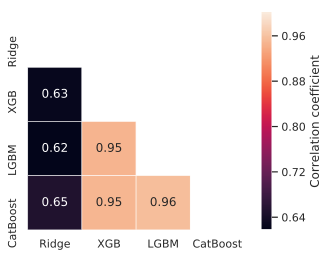

In [27]:
# Construct a DataFrame with each model's predictions
pdf = pd.DataFrame()
pdf['Ridge'] = preds_br
pdf['XGB'] = preds_xgb
pdf['LGBM'] = preds_lgb
pdf['CatBoost'] = preds_cb

# Plot the correlation matrix
corr = pdf.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")
sns.heatmap(corr, mask=mask, annot=True,
            square=True, linewidths=.5,
            cbar_kws={'label': 'Correlation coefficient'})

On one hand, as we saw in the previous section the performance of the tree-based models is far better than the ridge regression.  On the other hand, the ridge regression's predictions aren't very highly correlated with the tree models', and including models whose predictions are not highly correlated in an ensemble usually leads to better performance.

How well can we predict customer loyalty if we average the predictions from all 4 models?

In [28]:
# Compute the averaged predictions
mean_preds = pdf.mean(axis=1)

# Compute RMSE of averaged predictions
root_mean_squared_error(y_train, mean_preds)

3.672942570454171

And if we only use the tree-based models?

In [29]:
# Compute the averaged predictions
mean_preds = pdf[['XGB', 'LGBM', 'CatBoost']].mean(axis=1)

# Compute RMSE of averaged predictions
root_mean_squared_error(y_train, mean_preds)

3.6627383574431644

Looks like adding the ridge regression doesn't really help the performance of the model when ensembling.

<a id='stacking-model'></a>
## Stacking Model

Another ensembling method is called [stacking](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking), which often performs even better than just averaging the predictions of the base learners.  With stacking, we first make predictions with the base learners.  Then, we use a separate "meta" model to make predictions for the target based of the predictions of the base learners.  That is, we train the meta learner with the features being the predictions of the base learners (and the target still being the target).

When stacking it's important to ensure you train the meta-learner on out-of-fold predictions of the base learners (i.e. make cross-fold predictions with the base learners and train the meta learner on those).  The `StackedRegressor` model we'll use below handles this for us (see the code for it [on my github](http://github.com/brendanhasz/dsutils/blob/master/src/dsutils/ensembling.py#L144)).

First let's try using all four models as base learners, and then a Bayesian ridge regression as the meta-learner:

In [30]:
%%time

# Create the ensemble regressor
model = StackedRegressor([ridge, xgboost, catboost, lgbm],
                         meta_learner=BayesianRidge())

# Performance of ensemble
cross_val_metric(model, X_train, y_train,
                 metric=root_mean_squared_error,
                 cv=3, display='RMSE')

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Cross-validated RMSE: 3.661 +/- 0.019
CPU times: user 1h 12min 5s, sys: 55.6 s, total: 1h 13min 1s
Wall time: 2h 43min 19s


And how well do we do if we just use the tree models?

In [31]:
%%time

# Create the ensemble regressor
model = StackedRegressor([xgboost, catboost, lgbm],
                         meta_learner=BayesianRidge())

# Performance of ensemble
cross_val_metric(model, X_train, y_train,
                 metric=root_mean_squared_error,
                 cv=3, display='RMSE')

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Cross-validated RMSE: 3.661 +/- 0.019
CPU times: user 1h 2min 22s, sys: 50.3 s, total: 1h 3min 13s
Wall time: 2h 4min 42s


Again, adding the ridge regression to the stacking ensemble didn't really seem to help either.  Since it's a bit faster, we'll use the stacking model which uses only the tree models.  Note that the ensemble model in this case is just barely better than the tree-based models by themselves!  

Finally, we just need to save our predictions to file:

In [32]:
# Fit model on training data
fit_model = model.fit(X_train, y_train)

# Predict on test data
predictions = fit_model.predict(X_test)

# Write predictions to file
df_out = pd.DataFrame()
df_out['card_id'] = X_test.index
df_out['target'] = predictions
df_out.to_csv('predictions.csv', index=False)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
